In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain
import os
import warnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
train = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

In [3]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [7]:
train.date = pd.to_datetime(train.date)

In [8]:
train.date.unique

<bound method Series.unique of 0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1457   2016-12-28
1458   2016-12-29
1459   2016-12-30
1460   2016-12-31
1461   2017-01-01
Name: date, Length: 1462, dtype: datetime64[ns]>

In [9]:
warnings.filterwarnings("ignore")

1. Data Visualization

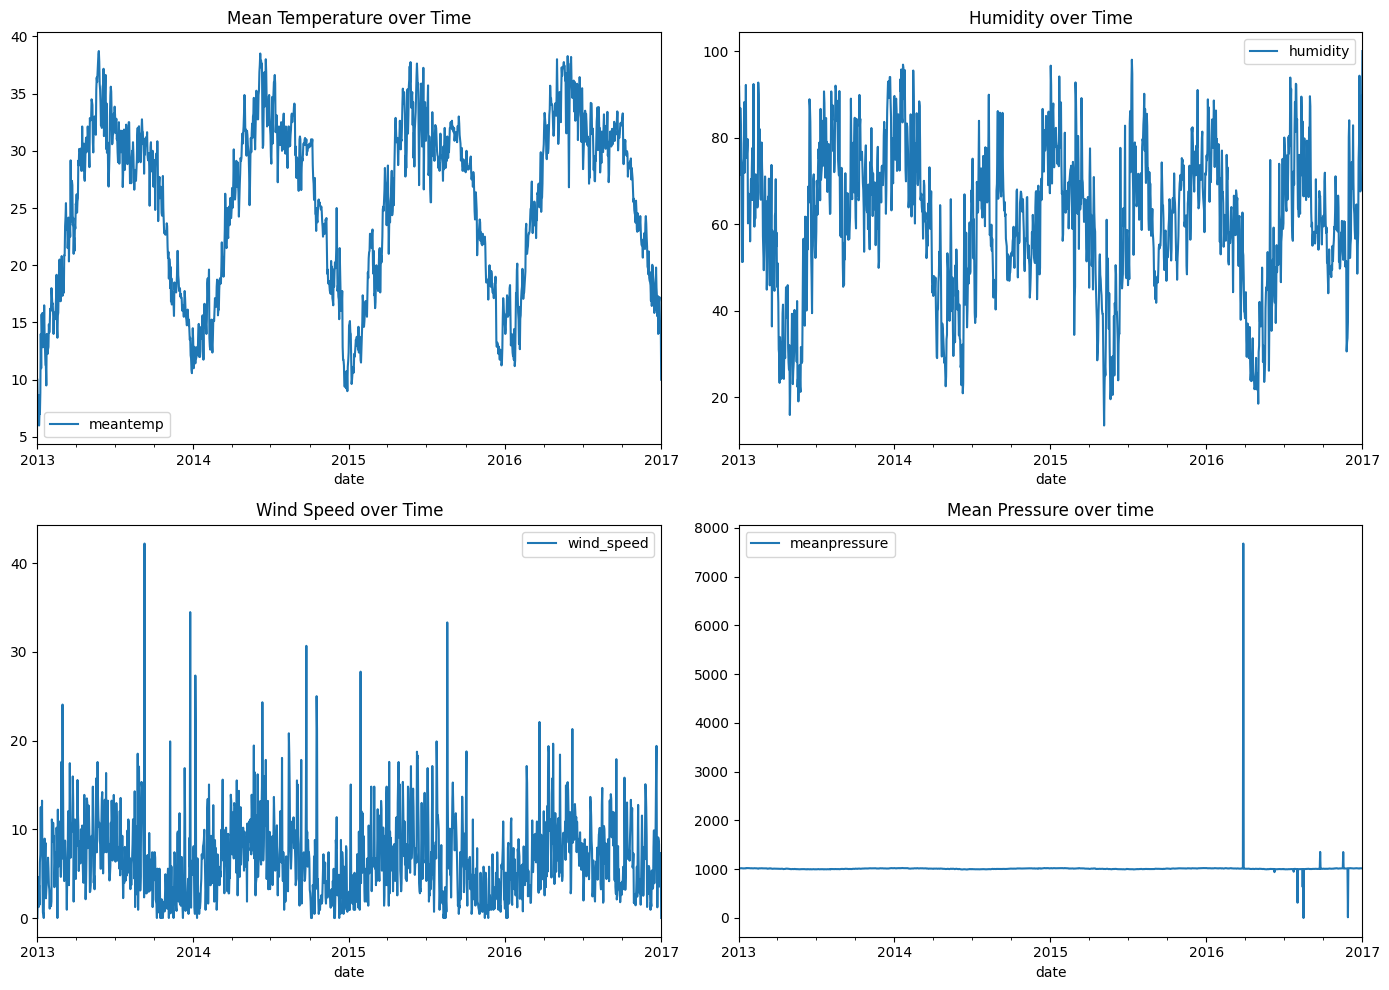

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
train.plot(x='date', y='meantemp', ax=axs[0,0], title='Mean Temperature over Time')  
train.plot(x='date', y='humidity', ax=axs[0,1], title='Humidity over Time')
train.plot(x='date', y='wind_speed', ax=axs[1,0], title='Wind Speed over Time')
train.plot(x='date', y='meanpressure', ax=axs[1,1], title='Mean Pressure over time')
plt.tight_layout()
plt.show()

2.Trends

In [11]:
train['time'] = np.arange(len(train.index))
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day_of_week'] = train['date'].dt.dayofweek+1
train['week'] = train['date'].dt.isocalendar().week
train['day'] = train['date'].dt.day
train['day_of_year'] = train['date'].dt.dayofyear

In [12]:
train

,date,meantemp,humidity,wind_speed,meanpressure,time,year,month,day_of_week,week,day,day_of_year
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,0,2013,1,2,1,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,1,3,1,2,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2,2013,1,4,1,3,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,3,2013,1,5,1,4,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,4,2013,1,6,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,1457,2016,12,3,52,28,363
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,1458,2016,12,4,52,29,364
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,1459,2016,12,5,52,30,365
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,1460,2016,12,6,52,31,366


In [13]:
month = train.groupby('month')[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].mean().reset_index()
year = train.groupby('year')[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].mean().reset_index()
week = train.groupby('week')[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].mean().reset_index()
day_of_week = train.groupby('day_of_week')[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].mean().reset_index()
day = train.groupby('day')[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].mean().reset_index()

In [14]:
month

,month,meantemp,humidity,wind_speed,meanpressure
0,1,13.311914,78.603500,4.945358,1018.152410
1,2,17.620422,67.959397,6.531042,1015.349232
2,3,22.914103,60.698463,7.696836,1066.531388
3,4,29.376614,39.036537,8.783093,1006.975741
4,5,33.315889,35.739941,9.022982,1001.975698
5,6,33.734011,50.628724,9.381606,997.878522
6,7,30.995782,70.631436,7.418752,998.040354
7,8,30.601777,70.469849,6.923782,984.358104
8,9,30.433216,60.724564,7.596360,1007.465067
9,10,27.113154,61.220659,4.761333,1010.509337


In [15]:
year

,year,meantemp,humidity,wind_speed,meanpressure
0,2013,24.791494,63.046292,6.827253,1007.642172
1,2014,25.010673,59.767942,6.756148,1008.347166
2,2015,25.114591,61.430490,6.480603,1008.834821
3,2016,27.103373,58.740174,7.162480,1019.557460
4,2017,10.000000,100.000000,0.000000,1016.000000


Month Trend

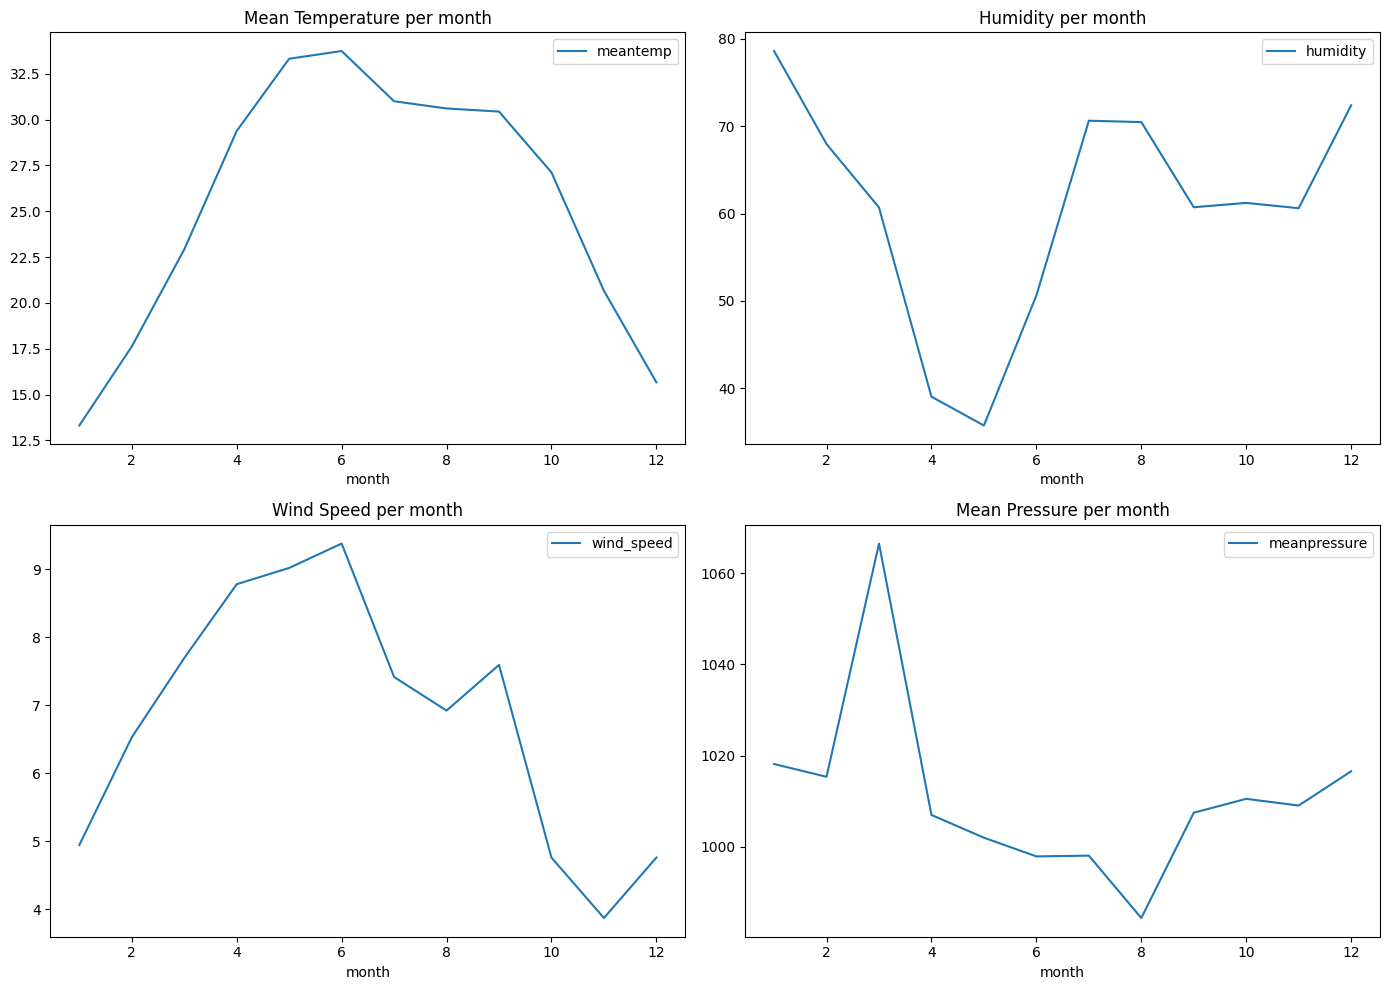

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
month.plot(x='month', y='meantemp', ax=axs[0,0], title='Mean Temperature per month')  
month.plot(x='month', y='humidity', ax=axs[0,1], title='Humidity per month')
month.plot(x='month', y='wind_speed', ax=axs[1,0], title='Wind Speed per month')
month.plot(x='month', y='meanpressure', ax=axs[1,1], title='Mean Pressure per month')
plt.tight_layout()
plt.show()

Year Trend

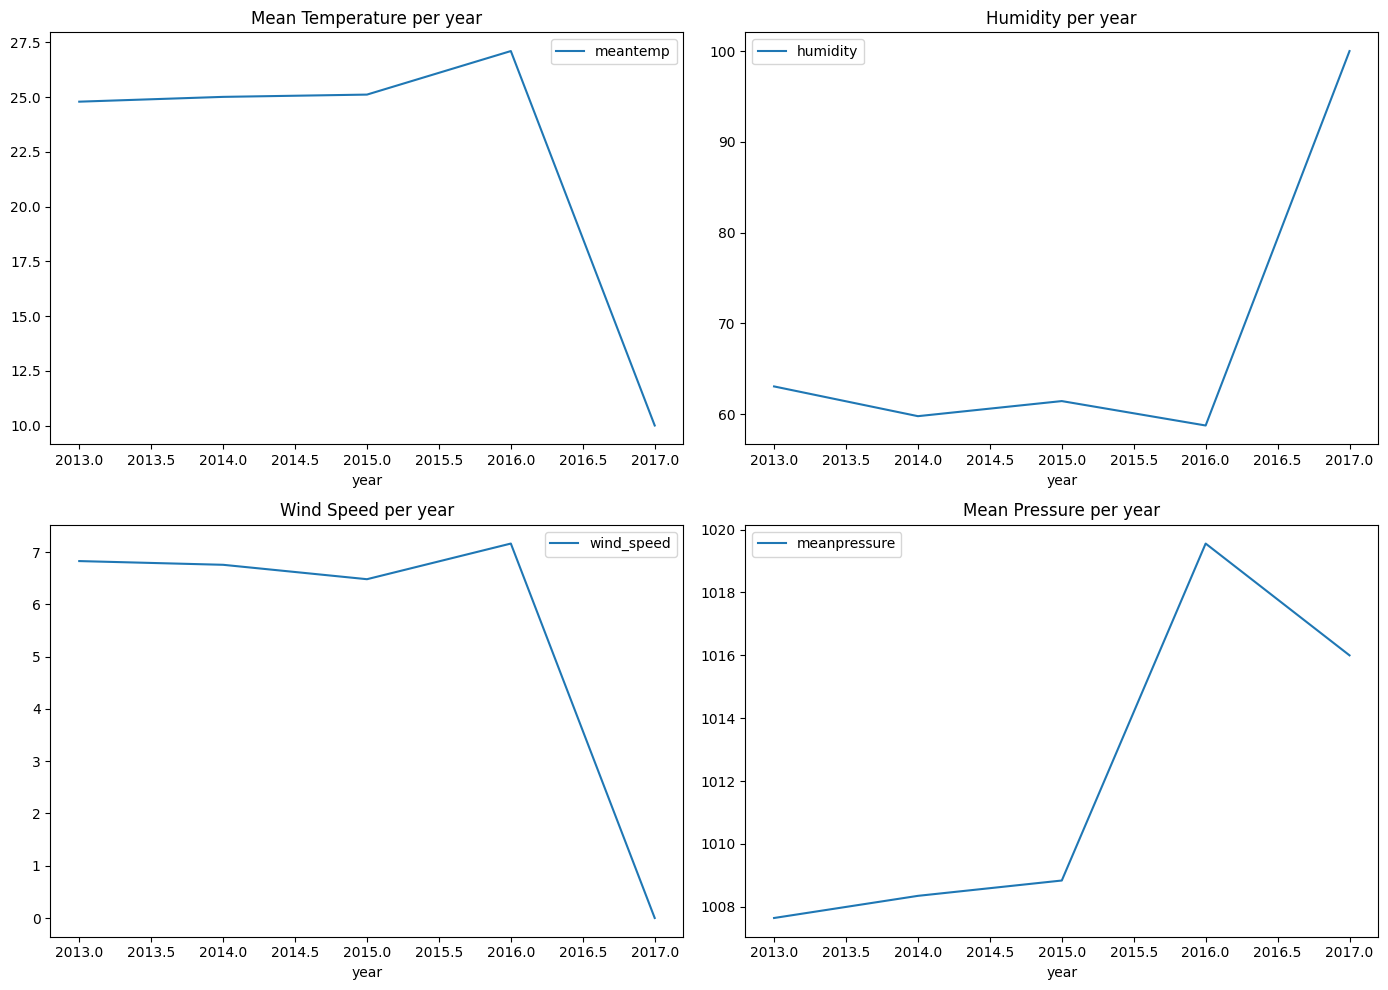

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
year.plot(x='year', y='meantemp', ax=axs[0,0], title='Mean Temperature per year') 
year.plot(x='year', y='humidity', ax=axs[0,1], title='Humidity per year')
year.plot(x='year', y='wind_speed', ax=axs[1,0], title='Wind Speed per year')
year.plot(x='year', y='meanpressure', ax=axs[1,1], title='Mean Pressure per year')
plt.tight_layout()
plt.show()

Week Trend

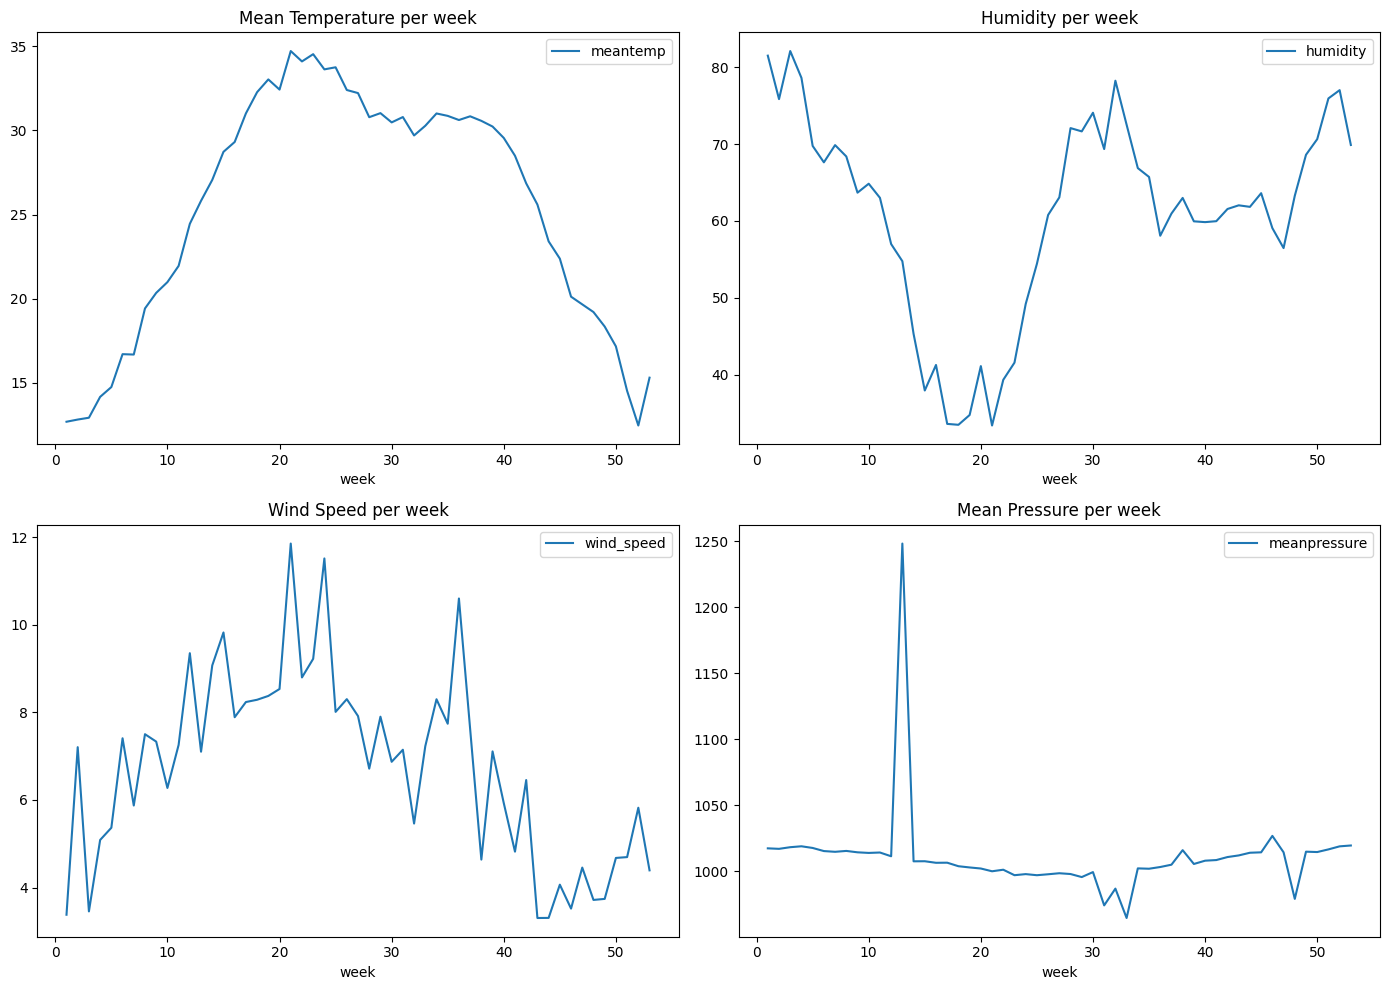

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
week.plot(x='week', y='meantemp', ax=axs[0,0], title='Mean Temperature per week')  
week.plot(x='week', y='humidity', ax=axs[0,1], title='Humidity per week')
week.plot(x='week', y='wind_speed', ax=axs[1,0], title='Wind Speed per week')
week.plot(x='week', y='meanpressure', ax=axs[1,1], title='Mean Pressure per week')
plt.tight_layout()
plt.show()

Day of week Trend

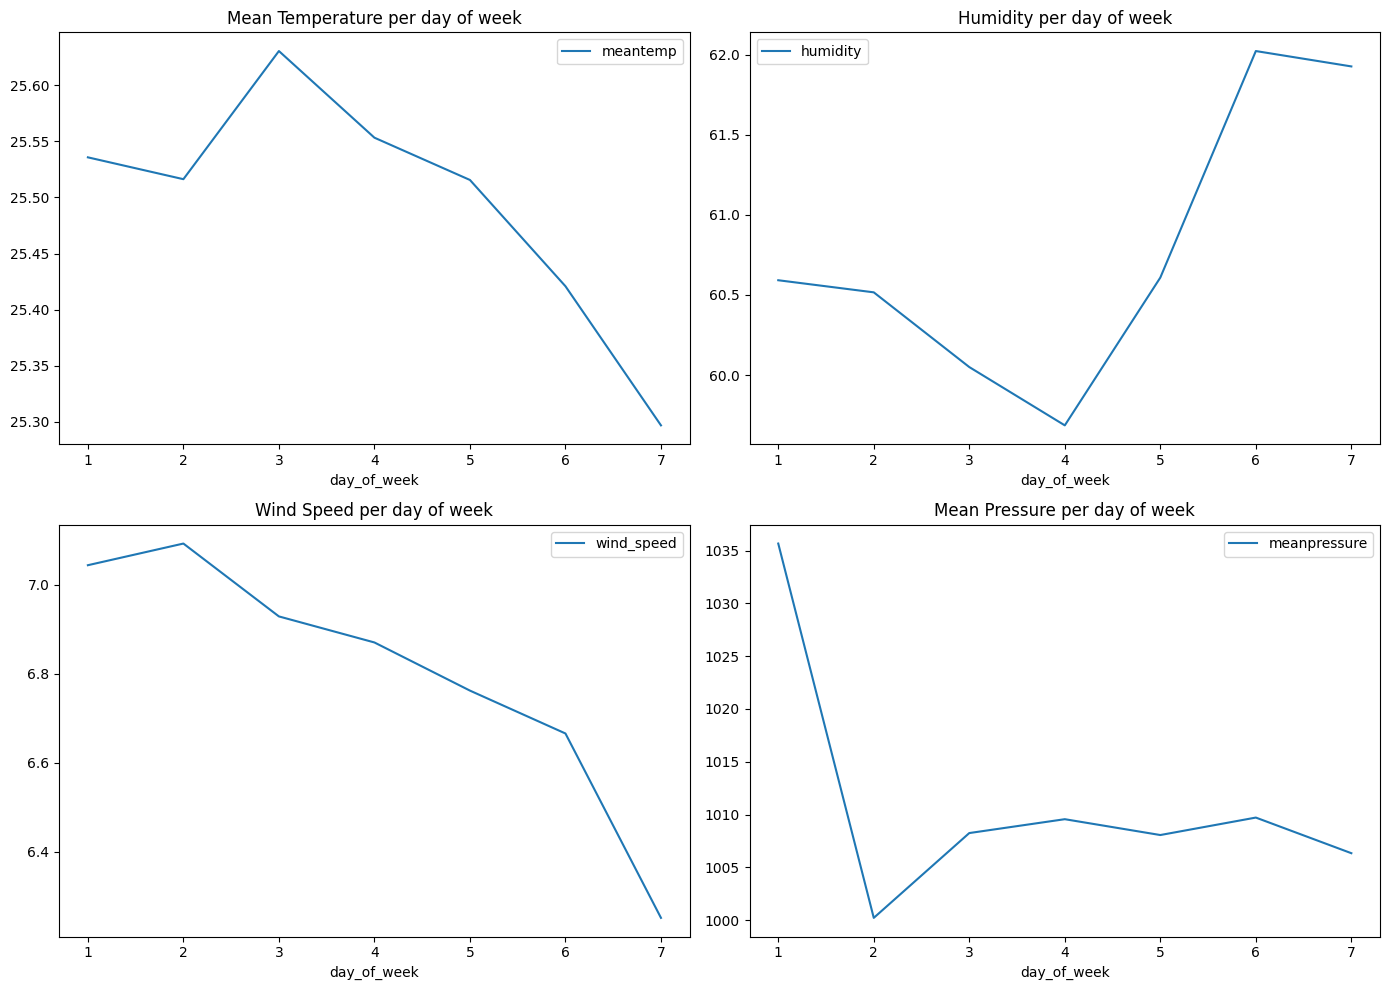

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
day_of_week.plot(x='day_of_week', y='meantemp', ax=axs[0,0], title='Mean Temperature per day of week')  
day_of_week.plot(x='day_of_week', y='humidity', ax=axs[0,1], title='Humidity per day of week')
day_of_week.plot(x='day_of_week', y='wind_speed', ax=axs[1,0], title='Wind Speed per day of week')
day_of_week.plot(x='day_of_week', y='meanpressure', ax=axs[1,1], title='Mean Pressure per day of week')
plt.tight_layout()
plt.show()

Day Trend

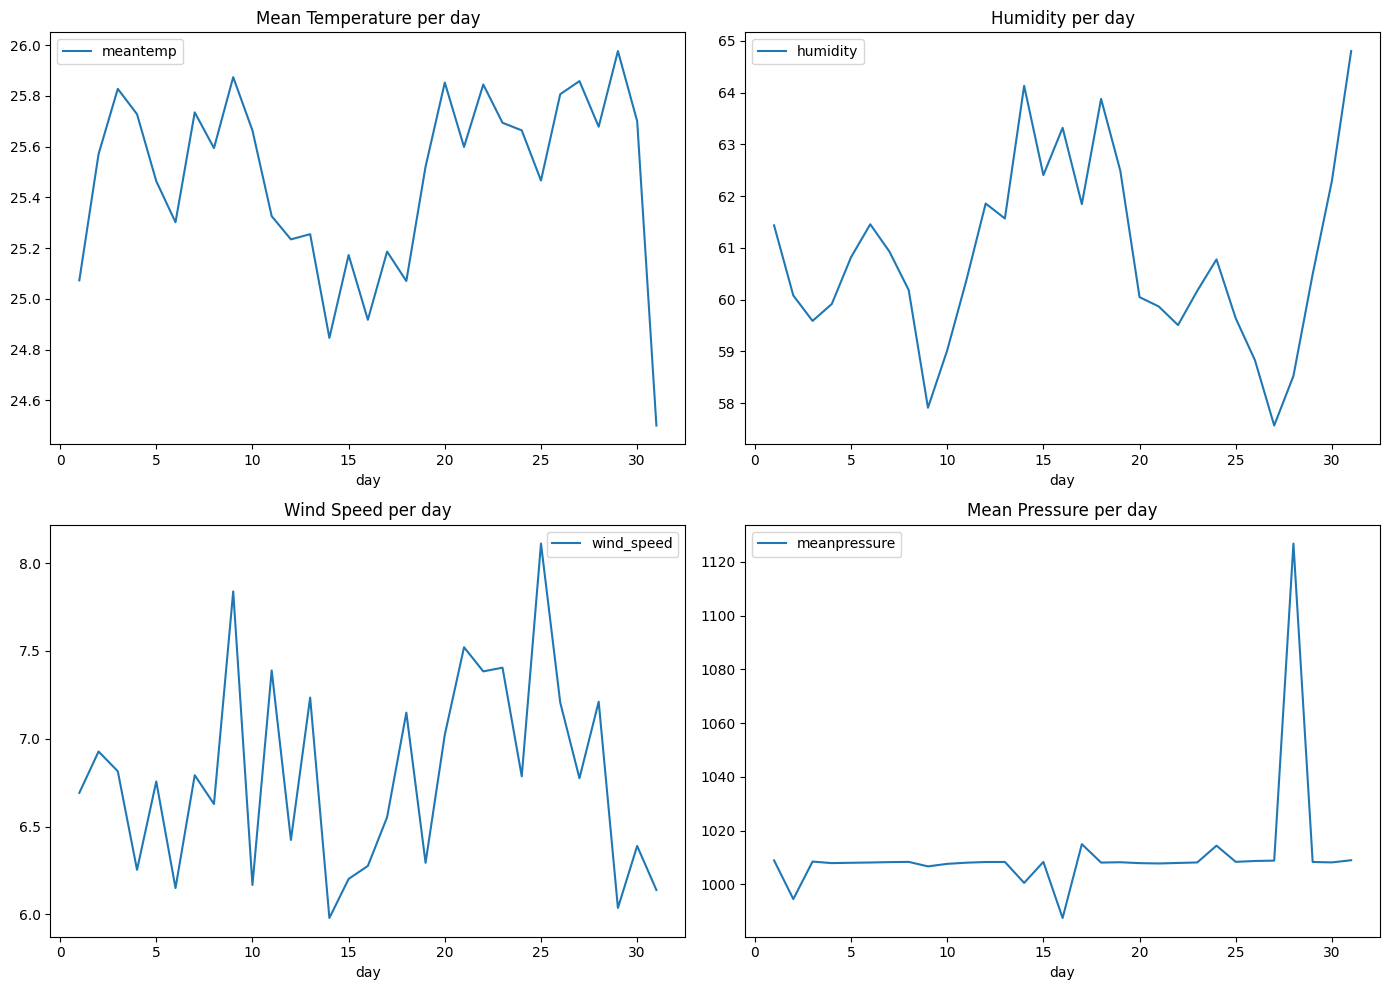

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
day.plot(x='day', y='meantemp', ax=axs[0,0], title='Mean Temperature per day')  
day.plot(x='day', y='humidity', ax=axs[0,1], title='Humidity per day')
day.plot(x='day', y='wind_speed', ax=axs[1,0], title='Wind Speed per day')
day.plot(x='day', y='meanpressure', ax=axs[1,1], title='Mean Pressure per day')
plt.tight_layout()
plt.show()

Lag Plots

In [21]:
month['lag_temp'] = month['meantemp'].shift(1)
month['lag_hum'] = month['humidity'].shift(1)
month['lag_wind'] = month['wind_speed'].shift(1)
month['lag_pres'] = month['meanpressure'].shift(1)

In [22]:
month

,month,meantemp,humidity,wind_speed,meanpressure,lag_temp,lag_hum,lag_wind,lag_pres
0,1,13.311914,78.603500,4.945358,1018.152410,NaN,NaN,NaN,NaN
1,2,17.620422,67.959397,6.531042,1015.349232,13.311914,78.603500,4.945358,1018.152410
2,3,22.914103,60.698463,7.696836,1066.531388,17.620422,67.959397,6.531042,1015.349232
3,4,29.376614,39.036537,8.783093,1006.975741,22.914103,60.698463,7.696836,1066.531388
4,5,33.315889,35.739941,9.022982,1001.975698,29.376614,39.036537,8.783093,1006.975741
5,6,33.734011,50.628724,9.381606,997.878522,33.315889,35.739941,9.022982,1001.975698
6,7,30.995782,70.631436,7.418752,998.040354,33.734011,50.628724,9.381606,997.878522
7,8,30.601777,70.469849,6.923782,984.358104,30.995782,70.631436,7.418752,998.040354
8,9,30.433216,60.724564,7.596360,1007.465067,30.601777,70.469849,6.923782,984.358104
9,10,27.113154,61.220659,4.761333,1010.509337,30.433216,60.724564,7.596360,1007.465067


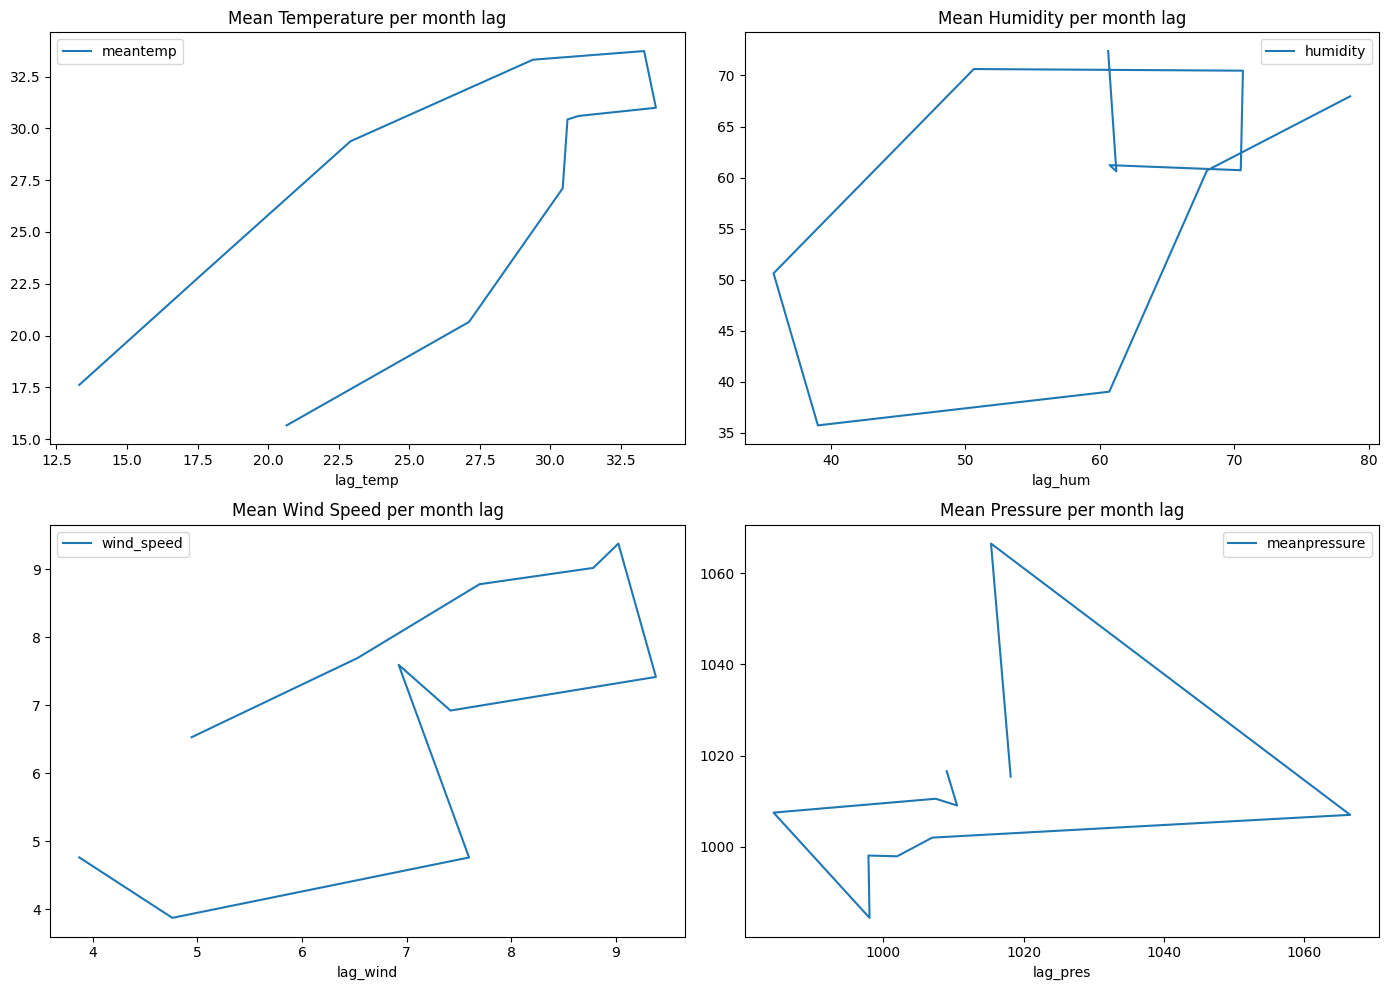

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
month.plot(x='lag_temp', y='meantemp', ax=axs[0,0], title='Mean Temperature per month lag')
month.plot(x='lag_hum', y='humidity', ax=axs[0,1], title='Mean Humidity per month lag')
month.plot(x='lag_wind', y='wind_speed', ax=axs[1,0], title='Mean Wind Speed per month lag')
month.plot(x='lag_pres', y='meanpressure', ax=axs[1,1], title='Mean Pressure per month lag')
plt.tight_layout()
plt.show()

In [24]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

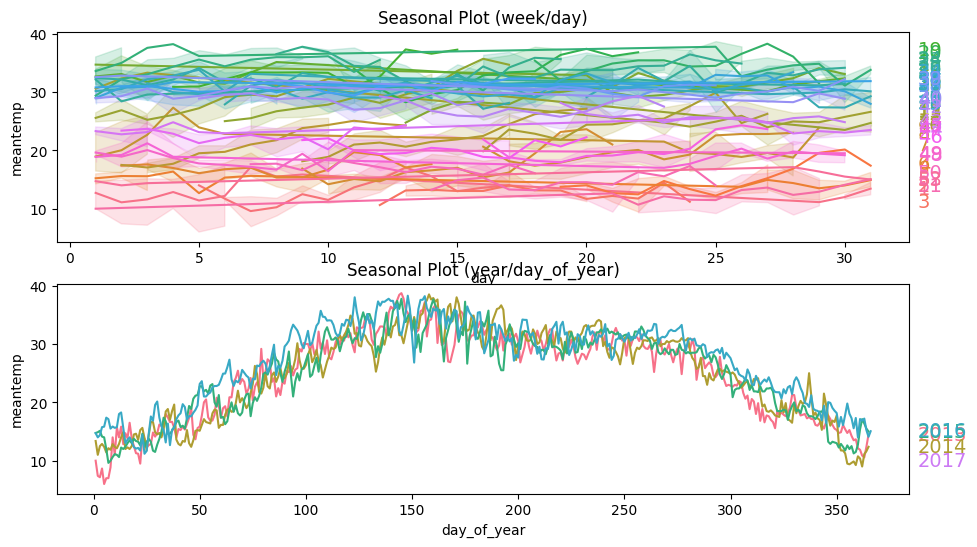

In [26]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(train, y="meantemp", period="week", freq="day", ax=ax0)
seasonal_plot(train, y="meantemp", period="year", freq="day_of_year", ax=ax1);

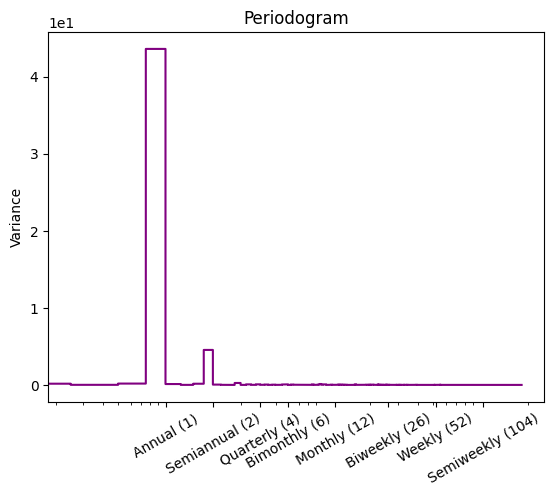

In [27]:
plot_periodogram(train['meantemp']);

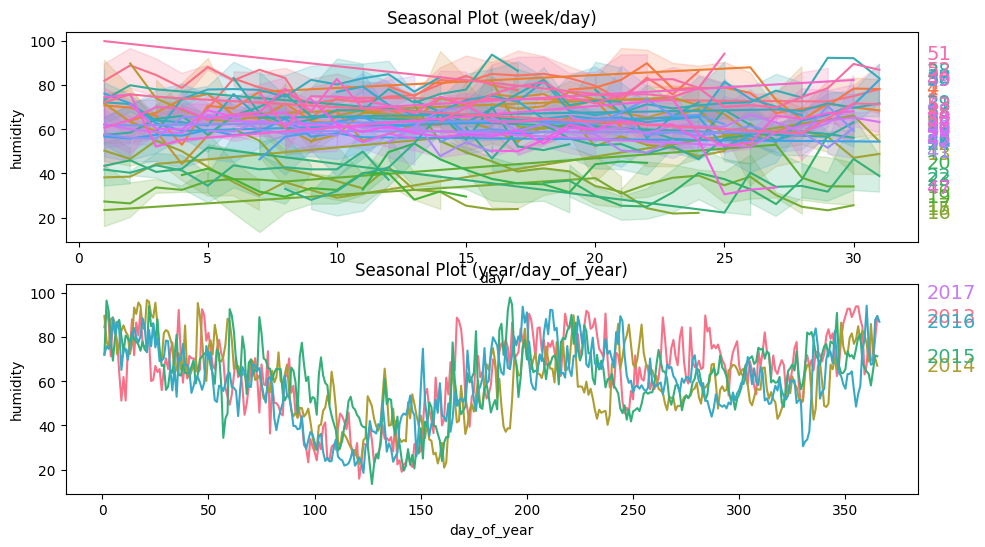

In [28]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(train, y="humidity", period="week", freq="day", ax=ax0)
seasonal_plot(train, y="humidity", period="year", freq="day_of_year", ax=ax1);

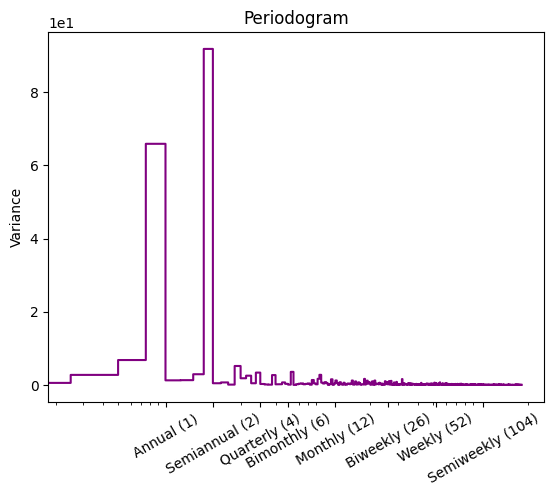

In [29]:
plot_periodogram(train['humidity']);

Forecasting

In [30]:
train.set_index('date', inplace=True)

In [31]:
test.set_index('date', inplace=True)

In [32]:
X_train = train[['humidity', 'wind_speed', 'meanpressure']]
y_train = train['meantemp']

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [34]:
X_test = test[['humidity', 'wind_speed', 'meanpressure']]
y_test = test['meantemp']

predictions = model.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 6.151449786666259


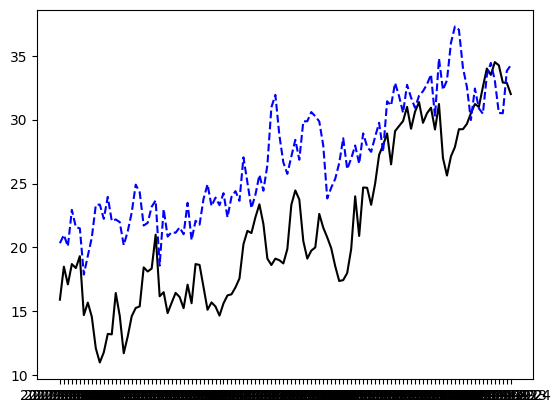

In [36]:
plt.plot(test.index, test['meantemp'], label='Actual', color='black')

# Machine Learning Model Forecast
plt.plot(test.index, predictions, label='Machine Learning (Linear Regression)', linestyle='--', color='blue')

In [37]:
order = (5, 1, 0)  # ARIMA parameters: (p, d, q)
model = ARIMA(train['meantemp'], order=order)
fitted_model = model.fit()

In [38]:
forecast = fitted_model.forecast(steps=len(test))
forecast_index = pd.date_range(start=test.index[0], periods=len(test))
forecast_series = pd.Series(forecast, index=forecast_index)


In [39]:
mse = mean_squared_error(test['meantemp'].iloc[1 :], forecast_series.dropna())
rmse = mse ** 0.5
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 11.4585226638482


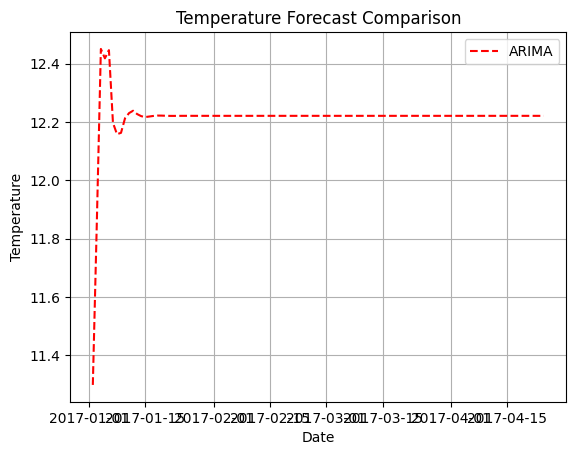

In [40]:
plt.plot(forecast_index, forecast_series, label='ARIMA', linestyle='--', color='red')

plt.title('Temperature Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()